In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
from scipy.linalg import block_diag

Let us define the system <br>
$$\begin{aligned}
x(k+1) &= \left[\begin{matrix}-2&0 \\ 0&3\end{matrix}\right]x(k)+\left[\begin{matrix}1 \\ 2\end{matrix}\right]u(k)\\
y(k) &= \left[\begin{matrix}1&0\end{matrix}\right]x(k)
\end{aligned}$$

In [3]:
A = np.array([[0.5,0.8],[-1.1,0.6]])
B = np.array([[0.8],[-0.6]])
C = np.array([[1,0]])
# A = np.array([[-2.0,1.0],[1.0,0.2]])
# B = np.array([[1.0],[0.0]])
# C = np.array([[1,0]])
n = A.shape[0]
m = B.shape[1]
print("A: \n",A,"\nShape:", A.shape)
print("A: \n",B,"\nShape:", B.shape)
print("A: \n",C,"\nShape:", C.shape)

A: 
 [[ 0.5  0.8]
 [-1.1  0.6]] 
Shape: (2, 2)
A: 
 [[ 0.8]
 [-0.6]] 
Shape: (2, 1)
A: 
 [[1 0]] 
Shape: (1, 2)


In [6]:
# Using CVXPY to solve the optimization problem
u_max = 5
x_max = np.array([[50],[50]])
Q = np.identity(n)
R = np.identity(m)
L = cp.Variable((n,n),symmetric=True)
M = cp.Variable((m,n))
N = cp.Variable((m,m),symmetric=True)
O = cp.Variable((n,n))

objective = cp.Minimize(-cp.trace(L))
constraints = [L>>0]
constraints += [cp.bmat([[0.9**2*L,L@A.T+M.T@B.T],[A@L+B@M,L]]) >> 0]
# print(Q@L)
# constraints += cp.bmat([[0.9**2*L,(A@L+B@M).T,(Q@L).T,(R@M).T],\
#     [A@L+B@M,L,np.zeros((2,2)),np.zeros((2,1))],\
#         [Q@L,np.zeros((2,2)),np.identity(n),np.zeros((2,1))],\
#             [R@M,np.zeros((1,2)),np.zeros((1,2)),np.identity(1)]] >> 0)
constraints += [cp.bmat([[N, M],[M.T,L]]) >> 0]
constraints += [u_max ** 2 - N >> 0]
# constraints += [cp.bmat([[O,np.identity(n)],[np.identity(n),L]]) >> 0]
# constraints += [np.diag(np.power(x_max,2)) - V >> 0]
# constraints += [O-L >> 0]
prob = cp.Problem(objective, constraints)

prob.solve()
P = np.linalg.inv(L.value)
ellipsoid = np.array([[],[]])
ii = 1000
for i in range(ii):
    phi = 2*np.pi/(ii)*(i+1)
    y = np.array([[np.cos(phi)],[np.sin(phi)]])
    gm = y.T@P@y
    ellipsoid = np.append(ellipsoid,y/np.sqrt(gm),axis=1)

plt.plot(ellipsoid[0,:],ellipsoid[1,:])
plt.grid()
plt.xlabel('x_1')
plt.ylabel('x_2')
plt.title('MPC Invariant Set')
plt.show
print(L.value)
print(P)

FATAL: Cannot solve SDPs with > 2x2 matrices without linked blas+lapack libraries
Install blas+lapack and re-compile SCS with blas+lapack library locations
ERROR: init_cone failure
Failure:could not initialize work


SolverError: Solver 'SCS' failed. Try another solver, or solve with verbose=True for more information.

In [ ]:
x_init = cp.Parameter((n,1))
noise = cp.Parameter((n,1))
Q_mat = []
R_mat = []
N = 10
for i in range(10):
    Q_mat = block_diag(Q_mat,Q)
    R_mat = block_diag(R_mat,R)

Q_mat = block_diag(Q_mat,P)
Q_mat = Q_mat[1:,:]
R_mat = R_mat[1:,:]
total_iter = 10000
X = cp.Variable(((N+1)*n,1))
u = cp.Variable((N*m,1))

# Constructing MPC problem
objective_MPC = 0
constraints_MPC = [X[0*n:1*n] == x_init] # Initial conditions
for j in range(N):
    constraints_MPC += [X[(j+1)*n:(j+2)*n] == A@X[(j)*n:(j+1)*n]+B@u[j*m:(j+1)*m]+noise] # Dynamic constraints
    constraints_MPC += [-u_max<=u[j*m:(j+1)*m],u[j*m:(j+1)*m]<=u_max] # Input constraints
    constraints_MPC += [-x_max<=X[(j)*n:(j+1)*n],X[(j)*n:(j+1)*n]<=x_max] # State constraints
    objective_MPC += cp.quad_form(X[(j)*n:(j+1)*n],Q) + cp.quad_form(u[j*m:(j+1)*m].T,R)

constraints_MPC += [cp.quad_form(X[(j+1)*n:(j+2)*n],P)<=1]
objective_MPC += cp.quad_form(X[(j+1)*n:(j+2)*n],P)
prob_MPC = cp.Problem(cp.Minimize(objective_MPC), constraints_MPC)

i=0
# Input information for the neural network
# x_past horizons
input_network = []
output_network = np.array([])
for iter in range(total_iter):
    x0 = np.array(np.random.rand(2,1)*30-15)
    if (len(input_network)==0):
        input_network = np.tile(x0,(1,N)).reshape(1,n,N)
    else:
        # input_network = input_network[:-n,:]
        input_network = np.append(input_network,np.tile(x0,(1,N)).reshape(1,n,N),axis=0)
    i = 0
    while i==0 or prob_MPC.value > 0.0000001:
        noise.value = np.random.rand(n,1)*0.0001
        if i > 0:
            x_init.value = X[1*n:2*n].value
        else:
            x_init.value = x0
        prob_MPC.solve(solver=cp.MOSEK)
        # print(prob_MPC.value)
        entry = X.value[1*n:2*n].reshape(2,1)
        new_input_network = np.append(input_network[-1:,:,1:].reshape(n,N-1),entry,axis=1)
        input_network = np.append(input_network,new_input_network.reshape(1,n,N),axis=0)
        # input_network = np.append(input_network,new_input_network[0,:].reshape(1,N),axis=0)
        # input_network = np.append(input_network,new_input_network[1,:].reshape(1,N),axis=0)
        output_network = np.append(output_network,u.value[0*m:1*m])
        i += 1
    
    input_network = input_network[:-1,:,:]

print(input_network.shape)
print(output_network.shape)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

<h3>Saving dataset</h3>

In [ ]:
# np.savetxt("input_dataset_wonoise.csv",input_network,delimiter=",")
np.savetxt("output_dataset_winoise.txt",output_network,delimiter=",")

# Write the array to disk
with open('input_dataset_winoise.txt', 'w') as outfile:
    # I'm writing a header here just for the sake of readability
    # Any line starting with "#" will be ignored by numpy.loadtxt
    outfile.write('# Array shape: {0}\n'.format(input_network.shape))
    
    # Iterating through a ndimensional array produces slices along
    # the last axis. This is equivalent to data[i,:,:] in this case
    for data_slice in input_network:

        # The formatting string indicates that I'm writing out
        # the values in left-justified columns 7 characters in width
        # with 2 decimal places.  
        np.savetxt(outfile, data_slice)

        # Writing out a break to indicate different slices...
        outfile.write('# New slice\n')

# To load the file, use the line below
# numpy.loadtxt('test.txt').reshape((4,5,10))

In [4]:
import tensorflow as tf
import datetime
import time

<h3>Split training and testing dataset

In [ ]:
# train_size = 0.8*input_network.shape[0]
# x_train = input_network[:int(np.around(train_size,-2)),:]
# y_train = output_network[:int(np.around(train_size,-2)/2)]
# x_test = input_network[int(np.around(train_size,-2)):,:]
# y_test = output_network[int(np.around(train_size,-2)/2):]
# print(x_test[100:102,:])
# print(x_test.shape)
# # x_train = x_train.reshape((int(np.around(train_size,-2)/2),n,N))
# x_train_new = np.zeros((x_train.reshape((int(np.around(train_size,-2)/2),n,N))).shape)
# x_test_new = np.zeros((x_test.reshape((int(x_test.shape[0]/2),n,N))).shape)
# for i in range(x_train_new.shape[0]):
#     x_train_new[i,:,:] = x_train[i*n:(i+1)*n,:]

# for i in range(x_test_new.shape[0]):
#     x_test_new[i,:,:] = x_test[i*n:(i+1)*n,:]
# # x_train = x_train[]
# print(x_test_new[50,:,:])
# print(x_test_new.shape)
# print(y_train.shape)
# print(y_test.shape)

[[-1.06066455 -1.06066455 -1.06066455 -1.06066455 -1.06066455 -1.06066455
   1.83989871  1.20720969  0.11631246 -0.26324367]
 [ 2.41550217  2.41550217  2.41550217  2.41550217  2.41550217  2.41550217
   2.28766037  0.50585861 -0.35543104 -0.31341102]]
(14396, 10)
[[-1.06066455 -1.06066455 -1.06066455 -1.06066455 -1.06066455 -1.06066455
   1.83989871  1.20720969  0.11631246 -0.26324367]
 [ 2.41550217  2.41550217  2.41550217  2.41550217  2.41550217  2.41550217
   2.28766037  0.50585861 -0.35543104 -0.31341102]]
(7198, 2, 10)
(28750,)
(7198,)


In [5]:
n = 2
N = 10
input_network = np.loadtxt('input_dataset_wonoise.txt').reshape((198319, 2, 10))
output_network = np.loadtxt('output_dataset_wonoise.txt').reshape((198319,))
print(input_network.shape)
print(output_network.shape)

(198319, 2, 10)
(198319,)


<h3>Split training and testing dataset - rev1</h3>

In [6]:
train_size = 0.8*input_network.shape[0]
x_train = input_network[:int(np.around(train_size,-2)),:,:]
x_test = input_network[int(np.around(train_size,-2)):,:,:]
y_train = output_network[:int(np.around(train_size,-2))]
y_test = output_network[int(np.around(train_size,-2)):]

In [8]:
coba = np.reshape(x_train,(x_train.shape[0],20))
coba_test = np.reshape(x_test,(x_test.shape[0],20))
print(coba[0,:])
print(x_train[0,:,:])

[14.5793363  14.5793363  14.5793363  14.5793363  14.5793363  14.5793363
 14.5793363  14.5793363  14.5793363  14.5793363   2.44213967  2.44213967
  2.44213967  2.44213967  2.44213967  2.44213967  2.44213967  2.44213967
  2.44213967  2.44213967]
[[14.5793363  14.5793363  14.5793363  14.5793363  14.5793363  14.5793363
  14.5793363  14.5793363  14.5793363  14.5793363 ]
 [ 2.44213967  2.44213967  2.44213967  2.44213967  2.44213967  2.44213967
   2.44213967  2.44213967  2.44213967  2.44213967]]


In [13]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(n*N)))
# model.add(tf.keras.layers.LSTM(10))
# model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(15, activation='relu'))
# model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(15, activation='relu'))
# model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1, activation='linear'))
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "traditional_NN_new"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
# loss_fn = tf.keras.losses.mse()
model.compile(optimizer='sgd',
              loss='mse')
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 15)                315       
_________________________________________________________________
dense_7 (Dense)              (None, 15)                240       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 16        
Total params: 571
Trainable params: 571
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.fit(coba,y_train,validation_split=0.1,epochs=1000,batch_size=200,callbacks=[tensorboard_callback])
model.evaluate(coba_test,y_test,verbose=2)

Epoch 1/1000
715/715 [==============================] - 3s 3ms/step - loss: 0.4498 - val_loss: 0.2091
Epoch 2/1000
715/715 [==============================] - 1s 2ms/step - loss: 0.1764 - val_loss: 0.1751
Epoch 3/1000
715/715 [==============================] - 1s 2ms/step - loss: 0.1597 - val_loss: 0.1889
Epoch 4/1000
715/715 [==============================] - 1s 2ms/step - loss: 0.1467 - val_loss: 0.1557
Epoch 5/1000
715/715 [==============================] - 1s 2ms/step - loss: 0.1369 - val_loss: 0.1834
Epoch 6/1000
715/715 [==============================] - 1s 2ms/step - loss: 0.1286 - val_loss: 0.1416
Epoch 7/1000
715/715 [==============================] - 1s 2ms/step - loss: 0.1209 - val_loss: 0.1212
Epoch 8/1000
715/715 [==============================] - 1s 2ms/step - loss: 0.1131 - val_loss: 0.1367
Epoch 9/1000
715/715 [==============================] - 2s 2ms/step - loss: 0.1050 - val_loss: 0.1188
Epoch 10/1000
715/715 [==============================] - 1s 2ms/step - loss: 0.097

0.0032653778325766325

In [406]:
model.save('without_noise_model_FFNN')

INFO:tensorflow:Assets written to: without_noise_model_FFNN\assets


INFO:tensorflow:Assets written to: without_noise_model_FFNN\assets


In [411]:
x0 = np.array(np.random.rand(2,1)*30-15)
total_iter = 100
x0_predict = np.tile(x0,(1,N))
print(x0_predict.reshape(n*N).shape)
for i in range(total_iter):
    u0 = model.predict(x0_predict.reshape(1,n*N))
    print(u0.shape)
    print(x0.shape)
    x_next = A@x0 + B@u0
    # print(x0_predict[1:,:].shape)
    # print(x_next.shape)
    x0_predict = np.append(x0_predict[:,1:],x_next,axis=1)
    x0 = x_next
    print(x_next)

(20,)
(1, 1)
(2, 1)
[[-5.74168449]
 [ 0.92956726]]
(1, 1)
(2, 1)
[[1.75440107]
 [3.96240116]]
(1, 1)
(2, 1)
[[2.37118305]
 [1.70455333]]
(1, 1)
(2, 1)
[[ 0.7452875 ]
 [-0.23260935]]
(1, 1)
(2, 1)
[[-0.28692757]
 [-0.60426897]]
(1, 1)
(2, 1)
[[-0.3338137]
 [-0.26674  ]]
(1, 1)
(2, 1)
[[-0.09869981]
 [-0.00404821]]
(1, 1)
(2, 1)
[[0.02437419]
 [0.04841887]]
(1, 1)
(2, 1)
[[0.03463744]
 [0.01445327]]
(1, 1)
(2, 1)
[[ 0.00881116]
 [-0.01437659]]
(1, 1)
(2, 1)
[[-0.01422212]
 [-0.01297341]]
(1, 1)
(2, 1)
[[-0.01203925]
 [ 0.00377238]]
(1, 1)
(2, 1)
[[0.00370175]
 [0.010479  ]]
(1, 1)
(2, 1)
[[0.00966378]
 [0.0026432 ]]
(1, 1)
(2, 1)
[[ 0.00101212]
 [-0.00459348]]
(1, 1)
(2, 1)
[[-0.00355783]
 [-0.0035776 ]]
(1, 1)
(2, 1)
[[-0.00244153]
 [ 0.00011746]]
(1, 1)
(2, 1)
[[0.00038592]
 [0.00162162]]
(1, 1)
(2, 1)
[[0.00107083]
 [0.00086303]]
(1, 1)
(2, 1)
[[0.00015925]
 [0.00013985]]
(1, 1)
(2, 1)
[[-5.90821684e-06]
 [ 5.67915537e-05]]
(1, 1)
(2, 1)
[[-5.68937292e-05]
 [ 1.15103619e-04]]
(1, 1)
(

In [6]:
wonoise_RNNmodel = tf.keras.models.load_model('without_noise_model')
winoise_RNNmodel = tf.keras.models.load_model('with_noise_model')
wonoise_LSTMmodel = tf.keras.models.load_model('without_noise_model_LSTM')
winoise_LSTMmodel = tf.keras.models.load_model('with_noise_model_LSTM')
wonoise_FFNNmodel = tf.keras.models.load_model('without_noise_model_FFNN')

In [113]:
wonoise_LSTMmodel.summary()
winoise_LSTMmodel.summary()
wonoise_RNNmodel.summary()
winoise_RNNmodel.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 10)                840       
                                                                 
 dense_12 (Dense)            (None, 1)                 11        
                                                                 
Total params: 851
Trainable params: 851
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 10)                840       
                                                                 
 dense_11 (Dense)            (None, 1)                 11        
                                                                 
Total params: 851
Trainable para

In [7]:
x_init_test = cp.Parameter((n,1))
noise_test = cp.Parameter((n,1))
Q_mat = []
R_mat = []
N = 10
for i in range(10):
    Q_mat = block_diag(Q_mat,Q)
    R_mat = block_diag(R_mat,R)

Q_mat = block_diag(Q_mat,P)
Q_mat = Q_mat[1:,:]
R_mat = R_mat[1:,:]
X_test = cp.Variable(((N+1)*n,1))
u_test = cp.Variable((N*m,1))

objective_MPC_test = 0
constraints_MPC_test = [X_test[0*n:1*n] == x_init_test] # Initial conditions
for j in range(N):
    constraints_MPC_test += [X_test[(j+1)*n:(j+2)*n] == A@X_test[(j)*n:(j+1)*n]+B@u_test[j*m:(j+1)*m]] # Dynamic constraints
    constraints_MPC_test += [-u_max<=u_test[j*m:(j+1)*m],u_test[j*m:(j+1)*m]<=u_max] # Input constraints
    # constraints_MPC_test += [-x_max<=X_test[(j)*n:(j+1)*n],X_test[(j)*n:(j+1)*n]<=x_max] # State constraints
    objective_MPC_test += cp.quad_form(X_test[(j)*n:(j+1)*n],Q) + cp.quad_form(u_test[j*m:(j+1)*m].T,R)

# constraints_MPC_test += [cp.quad_form(X_test[(j+1)*n:(j+2)*n],P)<=1]
objective_MPC_test += cp.quad_form(X_test[(j+1)*n:(j+2)*n],P)
prob_MPC_test = cp.Problem(cp.Minimize(objective_MPC_test), constraints_MPC_test)

In [226]:
import matplotlib.pyplot as plt
%matplotlib qt

Average time of MPC:  0.011959600448608398
Maximum time of MPC:  0.013361692428588867
Minimum time of MPC:  0.011002063751220703
Average time of FFNN:  0.03400816917419434
Maximum time of FFNN:  0.0380091667175293
Minimum time of FFNN:  0.03100728988647461


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
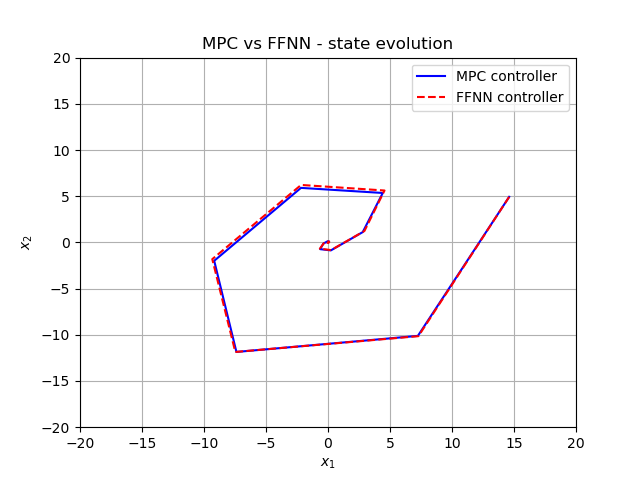

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
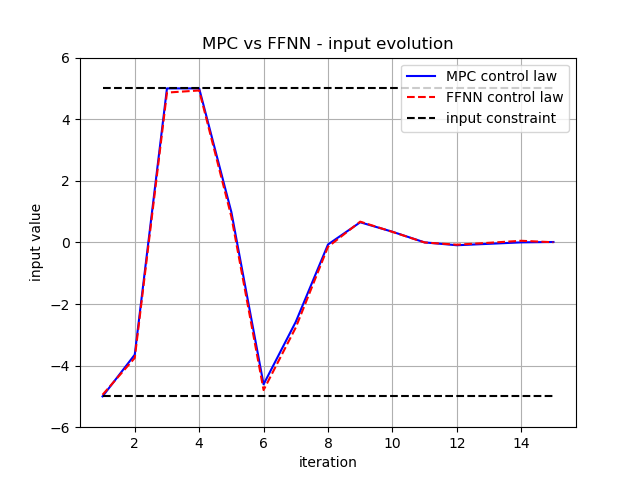

In [38]:
x0 = np.array(np.random.rand(2,1)*30-15)
# x0 = np.array([[-15],[15]])
total_iter = 15
# MPC initialization
x0_MPC = x0
x_save_MPC = np.array([[],[]])
u_save_MPC = np.array([])
time_save_MPC = np.array([])
# RNN initialization
x0_predict_RNN = np.tile(x0,(1,N))
x0_RNN = x0
x_save_RNN = np.array([[],[]])
u_save_RNN = np.array([])
# ANN result
x0_predict_FFNN = np.tile(x0,(1,N))
x0_FFNN = x0
x_save_FFNN = np.array([[],[]])
u_save_FFNN = np.array([])
time_save_FFNN = np.array([])
for i in range(total_iter):
    # saving to type
    noise_test = np.random.rand(n,1)*0
    t = time.time()
    # MPC section
    x_save_MPC = np.append(x_save_MPC,x0_MPC,axis=1)
    x_init_test.value = x0_MPC
    prob_MPC_test.solve(solver=cp.MOSEK)
    u0_MPC = u_test.value[0*m:1*m]
    x_next_MPC = A@x0_MPC + B@u0_MPC + noise_test
    x0_MPC = x_next_MPC
    u_save_MPC = np.append(u_save_MPC,u0_MPC)
    elapsed = time.time()-t
    time_save_MPC = np.append(time_save_MPC,elapsed)
    t = time.time()
    # FFNN section
    x_save_FFNN = np.append(x_save_FFNN,x0_FFNN,axis=1)
    u0_FFNN = wonoise_FFNNmodel.predict(x0_predict_FFNN.reshape(1,n*N))
    x_next_FFNN = A@x0_FFNN + B@u0_FFNN + noise_test
    x0_predict_FFNN = np.append(x0_predict_FFNN[:,1:],x_next_FFNN,axis=1)
    x0_FFNN = x_next_FFNN
    u_save_FFNN = np.append(u_save_FFNN,u0_FFNN)
    elapsed = time.time()-t
    time_save_FFNN = np.append(time_save_FFNN,elapsed)
    # other method section
    # x_save_RNN = np.append(x_save_RNN,x0_RNN,axis=1)
    # u0_RNN = wonoise_RNNmodel.predict(x0_predict_RNN.reshape(1,n,N))
    # x_next_RNN = A@x0_RNN + B@u0_RNN + noise_test
    # x0_predict_RNN = np.append(x0_predict_RNN[:,1:],x_next_RNN,axis=1)
    # x0_RNN = x_next_RNN
    # u_save_RNN = np.append(u_save_RNN,u0_RNN)
    
    # print(x_next)

print("Average time of MPC: ", np.average(time_save_MPC))
print("Maximum time of MPC: ", np.amax(time_save_MPC))
print("Minimum time of MPC: ", np.amin(time_save_MPC))
print("Average time of FFNN: ", np.average(time_save_FFNN))
print("Maximum time of FFNN: ", np.amax(time_save_FFNN))
print("Minimum time of FFNN: ", np.amin(time_save_FFNN))
# # print(x_save_LSTMwonoise)
%matplotlib widget
fig1, ax1 = plt.subplots()
ax1.plot(x_save_MPC[0,:],x_save_MPC[1,:],'b-',label='MPC controller')
ax1.plot(x_save_FFNN[0,:],x_save_FFNN[1,:],'r--',label='FFNN controller')
# ax1.plot(x_save_FFNN[0,:],x_save_RNN[1,:],'g-.',label='RNN controller')
ax1.set_title('MPC vs FFNN - state evolution')
ax1.set_xlim((-20,20))
ax1.set_ylim((-20,20))
ax1.set_xlabel('$x_1$')
ax1.set_ylabel('$x_2$')
ax1.legend(loc='upper right')
ax1.grid()
fig2, ax2 = plt.subplots()
ax2.plot(np.linspace(1, total_iter, num=total_iter),u_save_MPC,'b-',label='MPC control law')
ax2.plot(np.linspace(1, total_iter, num=total_iter),u_save_FFNN,'r--',label='FFNN control law')
# ax2.plot(np.linspace(1, total_iter, num=total_iter),u_save_RNN,'g-.',label='RNN control law')
ax2.plot(np.linspace(1, total_iter, num=total_iter),np.tile(u_max,total_iter),'k--',label='input constraint')
ax2.plot(np.linspace(1, total_iter, num=total_iter),np.tile(-u_max,total_iter),'k--')
ax2.set_title('MPC vs FFNN - input evolution')
ax2.set_ylim((-u_max-1,u_max+1))
ax2.set_xlabel('iteration')
ax2.set_ylabel('input value')
ax2.grid()
ax2.legend(loc='upper right')